In [1]:
import sys
!{sys.executable} -m pip uninstall torch torchvision torchaudio -y

!{sys.executable} -m pip install torch --index-url https://download.pytorch.org/whl/cu124

!{sys.executable} -m pip install catboost pytorch-tabnet sdv xgboost lightgbm

Found existing installation: torch 2.6.0+cu124


Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu124


  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp313-cp313-win_amd64.whl.metadata (28 kB)
Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp313-cp313-win_amd64.whl (2532.3 MB)

In [2]:
import random
import copy
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import save_data as save_data

#PREPROCESSING
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_validate, StratifiedKFold

#GENERATIVE MODELS
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer
import torch.nn as nn
import torch.optim as optim

#PREDICATIVE MODELS
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.linear_model import Ridge

#METRICS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 
#DATASETS
from sklearn.datasets import fetch_california_housing

# Setup

In [176]:
RANDOM_STATE = 43
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

model_gen = "vae"
#ratios = [0, 0.33, 0.67, 1.0]
n_samples_ratio = 0.25

# Helper Classes and Functions

In [177]:
def convert_dataset_to_dataframe(target, dataset=None, path=None):
    if path is not None:
        if '.csv' in path[-4:]:
            df = pd.read_csv(path)
            df.rename(columns={target: 'Target'}, inplace=True)
            return df
        else:
            return concat_sets(path)
    
    if dataset is None:
        raise ValueError("Missing one of the following parameters: 'dataset' ou 'path'.")

    try:
        if hasattr(dataset, 'data') and hasattr(dataset, 'feature_names'): 
            df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
        elif isinstance(dataset, pd.DataFrame):
            df = dataset.copy() 
        elif isinstance(dataset, np.ndarray):
            df = pd.DataFrame(dataset)
        elif isinstance(dataset, tuple):
            df = pd.concat([dataset[0], dataset[1]], axis=1)
        else:
            raise TypeError(f"There's no conversion for '{type(dataset).__name__}'.")


        if target in df.columns:
            df.rename(columns={target: 'Target'}, inplace=True)
        else:
            print(f"The given target '{target}' it's not a column of the dataset.")

        return df

    except Exception as e:
        print(f"Conversion Error: {e}")
        return None

# Graphs

In [178]:
#Correlation Graph
def show_corr_graph(data, cat_cols, ord_cols):
    data_copy = data.copy()
    
    encoder_nominal = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")
    encoder_ordinal = OrdinalEncoder().set_output(transform="pandas")

    encoded_ordinal_cols = encoder_ordinal.fit_transform(data_copy[ord_cols])

    data_copy[ord_cols] = encoded_ordinal_cols

    encoded_nominal_cols = encoder_nominal.fit_transform(data_copy[cat_cols])

    encoded_nominal_cols  = pd.DataFrame(
        encoded_nominal_cols, 
        columns=encoder_nominal.get_feature_names_out(cat_cols),
        index=data_copy.index
    )
    
    # Replace categorical columns with encoded ones
    data_copy = pd.concat([data_copy.drop(cat_cols, axis=1), encoded_nominal_cols], axis=1)
    
    corr_target = data_copy.corr()['Target'].drop('Target')
    
    plt.figure(figsize=(8, 18))
    corr_target.sort_values().plot(kind='barh', fontsize=8)
    plt.title('Feature correlation with target variable')
    plt.xlabel('Correlation')
    plt.tight_layout()
    plt.show()

In [179]:
def draw_learning_curve(ratios, scores, model_gen, pred_model):

    fig = plt.figure(figsize=(20, 5 ))

    # R2
    ax = plt.subplot(1, 2, 1)
    ax.plot(ratios, scores["R2"].to_list(), marker="o")
    ax.set_xlabel("Synthetic data ratio")
    ax.set_ylabel("R2 (OOF)")
    ax.set_title(f"{pred_model} — R2")

    # RMSE
    ax = plt.subplot(1, 2, 2)
    ax.plot(ratios, scores["RMSE"].to_list(), marker="o")
    ax.set_xlabel("Synthetic data ratio")
    ax.set_ylabel("RMSE (OOF)")
    ax.set_title(f"{pred_model} — RMSE")

    fig.suptitle(
        f"Learning Curve with Synthetic Data ({model_gen}) — OOF",
        fontsize=16
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Data Cleaner

In [180]:
class DataCleaner():
    
    def show_and_impute_missing_data(self, df, mode='mean'):
        plt.figure(figsize=(18,4),dpi=300) 
        null_count = df.isnull().sum().sort_values(ascending=False)


        null_count = null_count[null_count > 0]

        if (len(null_count) > 0):
            plt.figure(figsize=(20, 6))
            sns.barplot(y=null_count.values, x=null_count.index, palette='viridis')
            plt.title('Number of null values per features')
            plt.xlabel('Total of Nulls')
            plt.ylabel('Features')
            plt.xticks(rotation=90)
            plt.show()

            for cloumn in null_count.index:
                if df[cloumn].dtype == 'object' or str(df[cloumn].dtype).startswith('category'):
                    df[cloumn] = df[cloumn].fillna(df[cloumn].mode()[0])
                elif mode=='median':
                    df[cloumn] = df[cloumn].fillna(df[cloumn].median())
                elif mode=='mean':
                    df[cloumn] = df[cloumn].fillna(df[cloumn].mean())

        else:
            print("There is no value missing.")

    def remove_duplicated_data(self, df):
        num_dupli_lines = df.duplicated().sum()
        print(f"There are {num_dupli_lines} duplicated samples that will be removed")

        if (num_dupli_lines > 0 ):
            df.drop_duplicates(keep='first')

## Data Augmentor

### Generative Models

#### DDPM
Denoising Diffusion Probabilistic Model

In [181]:

class DiffusionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
  
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)
        )
  
        self.input_embed = nn.Linear(input_dim, hidden_dim)
        

        self.block1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.block2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.block3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        

        self.final = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.ReLU()

    def forward(self, x, t):

        t_emb = self.time_embed(t.float().view(-1, 1))
        x_emb = self.input_embed(x)
        h = self.activation(x_emb + t_emb)
        

        h = h + self.block1(h) 
        h = h + self.block2(h)
        h = h + self.block3(h)
        return self.final(h)


class DiffusionModel:
    def __init__(self, input_dim, n_steps=100, device='cpu'):
        self.n_steps = n_steps
        self.device = device
        self.model = DiffusionNetwork(input_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        self.beta = torch.linspace(1e-4, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def train_one_batch(self, x0):
        self.model.train()
 
        t = torch.randint(0, self.n_steps, (x0.shape[0],), device=self.device).long()

        epsilon = torch.randn_like(x0)
      
        sqrt_alpha = torch.sqrt(self.alpha_hat[t]).view(-1, 1)
        sqrt_one_minus = torch.sqrt(1 - self.alpha_hat[t]).view(-1, 1)
        x_t = sqrt_alpha * x0 + sqrt_one_minus * epsilon
  
        pred_epsilon = self.model(x_t, t.float() / self.n_steps)

        loss = self.criterion(pred_epsilon, epsilon)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    @torch.no_grad()
    def sample(self, n_samples):
        self.model.eval()
        x = torch.randn((n_samples, self.model.final.out_features)).to(self.device)
        for i in reversed(range(self.n_steps)):
            t = torch.tensor([i] * n_samples, device=self.device)
            pred_eps = self.model(x, t.float() / self.n_steps)
            alpha_t, alpha_hat_t, beta_t = self.alpha[i], self.alpha_hat[i], self.beta[i]
            
            noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
            term1 = 1 / torch.sqrt(alpha_t)
            term2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)
            x = term1 * (x - term2 * pred_eps) + torch.sqrt(beta_t) * noise
        return x


def get_synthetic_data_ddpm(X_in, y_in, n_samples_ratio=0.5, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

    if hasattr(X_in, "toarray"): X_in = X_in.toarray() 
    if hasattr(X_in, "values"): X_in = X_in.values
    if hasattr(y_in, "values"): y_in = y_in.values
    

    y_in = y_in.reshape(-1, 1)
    

    data_combined = np.hstack([X_in, y_in])
    

    internal_scaler = StandardScaler()
    data_scaled = internal_scaler.fit_transform(data_combined)
    

    dataset = torch.tensor(data_scaled, dtype=torch.float32).to(device)
    ddpm = DiffusionModel(input_dim=dataset.shape[1], n_steps=50, device=device)
    
    batch_size = min(256, len(dataset))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for _ in range(epochs):
        for batch in dataloader:
            ddpm.train_one_batch(batch)
            

    n_samples = int(len(X_in) * n_samples_ratio)
    generated_scaled = ddpm.sample(n_samples).cpu().numpy()
    

    generated_data = internal_scaler.inverse_transform(generated_scaled)
    

    X_syn = generated_data[:, :-1]
    y_syn = generated_data[:, -1]
    
    return X_syn, y_syn

#### GAN
Generative Adversarial Network

In [182]:

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim)

        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


def get_synthetic_data_gan(X_in, y_in, n_samples_ratio=0.5, epochs=100, latent_dim=64):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    if hasattr(X_in, "toarray"): X_in = X_in.toarray()
    if hasattr(X_in, "values"): X_in = X_in.values
    if hasattr(y_in, "values"): y_in = y_in.values
    

    y_in = y_in.reshape(-1, 1)
    data_combined = np.hstack([X_in, y_in])
    

    internal_scaler = StandardScaler()
    data_scaled = internal_scaler.fit_transform(data_combined)
    

    real_data = torch.tensor(data_scaled, dtype=torch.float32).to(device)
    data_dim = real_data.shape[1]
    

    generator = Generator(latent_dim, data_dim).to(device)
    discriminator = Discriminator(data_dim).to(device)
    
    # Optimizers
    lr = 0.0002
    opt_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    criterion = nn.BCELoss() 
    
    batch_size = min(128, len(real_data))
    n_batches = int(np.ceil(len(real_data) / batch_size))
    
    generator.train()
    discriminator.train()
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(real_data))
        
        for i in range(n_batches):
            idx = indices[i*batch_size : (i+1)*batch_size]
            real_batch = real_data[idx]
            curr_batch_size = real_batch.size(0)


            real_labels = torch.ones(curr_batch_size, 1).to(device)
            fake_labels = torch.zeros(curr_batch_size, 1).to(device)


            opt_d.zero_grad()
            

            outputs = discriminator(real_batch)
            d_loss_real = criterion(outputs, real_labels)


            z = torch.randn(curr_batch_size, latent_dim).to(device)
            fake_batch = generator(z)
            outputs = discriminator(fake_batch.detach()) 
            d_loss_fake = criterion(outputs, fake_labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            opt_d.step()
            

            opt_g.zero_grad()
            
            outputs = discriminator(fake_batch)
            g_loss = criterion(outputs, real_labels) 
            
            g_loss.backward()
            opt_g.step()

    generator.eval()
    n_samples = int(len(X_in) * n_samples_ratio)
    
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        generated_scaled = generator(z).cpu().numpy()
        
    generated_data = internal_scaler.inverse_transform(generated_scaled)
    
    X_syn = generated_data[:, :-1]
    y_syn = generated_data[:, -1]
    
    return X_syn, y_syn

#### VAE
Variational autoencoder

In [183]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16, hidden_dim=128):
        super().__init__()
        self.act = nn.ReLU()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = self.act(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.act(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


def vae_loss(x, x_hat, mu, logvar):
    recon_loss = nn.MSELoss()(x_hat, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl


def get_synthetic_data_vae(
    X_in, y_in,
    n_samples_ratio=0.5,
    epochs=80,
    latent_dim=16,
    hidden_dim=128,
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if hasattr(X_in, "toarray"): X_in = X_in.toarray()
    if hasattr(X_in, "values"): X_in = X_in.values
    if hasattr(y_in, "values"): y_in = y_in.values

    y_in = y_in.reshape(-1, 1)

    data_combined = np.hstack([X_in, y_in])

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_combined)

    data_t = torch.tensor(data_scaled, dtype=torch.float32).to(device)
    input_dim = data_t.shape[1]

    model = VAE(input_dim, latent_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    batch_size = min(256, len(data_t))
    loader = torch.utils.data.DataLoader(data_t, batch_size=batch_size, shuffle=True)

    model.train()
    for _ in range(epochs):
        for batch in loader:
            x_hat, mu, logvar = model(batch)
            loss = vae_loss(batch, x_hat, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Generate synthetic samples
    model.eval()
    n_samples = int(len(X_in) * n_samples_ratio)

    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        generated_scaled = model.decode(z).cpu().numpy()

    # Inverse scale
    generated_data = scaler.inverse_transform(generated_scaled)

    # Split back
    X_syn = generated_data[:, :-1]
    y_syn = generated_data[:, -1]

    return X_syn, y_syn


#### SDV (Synthetic Data Vault - library)
- CTGAN
- TVAE
- CopulaGAN

In [184]:
def get_synthetic_data_sdv(X_in, y_in, model_name="ctgan", n_samples_ratio=0.5):
    if hasattr(X_in, "toarray"):
        X_in = X_in.toarray()


    X_arr = X_in.values if hasattr(X_in, "values") else X_in
    y_arr = y_in.values if hasattr(y_in, "values") else y_in
    y_arr = y_arr.reshape(-1, 1)


    n_features = X_arr.shape[1]
    col_names = [f"col_{i}" for i in range(n_features)] + ["target"]
    
    data_combined = np.hstack([X_arr, y_arr])
    df_temp = pd.DataFrame(data_combined, columns=col_names)


    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df_temp)

    is_using_gpu = torch.cuda.is_available()
    
    if model_name.lower() == "tvae":
        model = TVAESynthesizer(
            metadata,
            enable_gpu=is_using_gpu
        )
    elif model_name.lower() == "copulagan":
        model = CopulaGANSynthesizer(
            metadata,
            enable_gpu=is_using_gpu
        )
    else:
        model = CTGANSynthesizer(
            metadata,
            enable_gpu=is_using_gpu,
            verbose=True
        )


    model.fit(df_temp)
    
    n_samples = int(len(X_arr) * n_samples_ratio)
    synthetic_df = model.sample(num_rows=n_samples)


    data_syn = synthetic_df.values
    
    X_syn = data_syn[:, :-1]
    y_syn = data_syn[:, -1]

    return X_syn, y_syn


def get_synthetic_data_ctgan(X_in, y_in, n_samples_ratio=0.5):
    return get_synthetic_data_sdv(X_in, y_in, model_name="ctgan", n_samples_ratio=n_samples_ratio)

def get_synthetic_data_tvae(X_in, y_in, n_samples_ratio=0.5):
    return get_synthetic_data_sdv(X_in, y_in, model_name="tvae", n_samples_ratio=n_samples_ratio)

def get_synthetic_data_copulagan(X_in, y_in, n_samples_ratio=0.5):
    return get_synthetic_data_sdv(X_in, y_in, model_name="copulagan", n_samples_ratio=n_samples_ratio)
    

In [185]:
gen_model_params = {
    "DDPM" : {
        "n_samples_ratio": n_samples_ratio,
        "epochs": 100
    },
    "GAN" : {
        "n_samples_ratio": n_samples_ratio,
        "epochs": 100, 
        "latent_dim": 64
    },
    "VAE" : {
        "n_samples_ratio": n_samples_ratio,
        "epochs":80,
        "latent_dim":16,
        "hidden_dim":128,
    },
    "CTGAN" : {
        "n_samples_ratio": n_samples_ratio,
    },
    "TVAE" : {
        "n_samples_ratio": n_samples_ratio,
    },
    "COPULAGAN" : {
        "n_samples_ratio": n_samples_ratio,
    }
}

In [186]:
def augment_data(model_name, X_train, y_train, n_samples_ratio = 0.5, params={}):
    if model_name.upper() in gen_model_params.keys():
        params = gen_model_params[model_name.upper()]
        params["n_samples_ratio"] = n_samples_ratio
    else:
        raise ValueError(f"The generative model {model_name} is unknown.")
    

    if model_name.upper() == "DDPM":
        X_syn, y_syn = get_synthetic_data_ddpm(X_train, y_train, **params)
        X_tr = np.vstack([X_train, X_syn])
        y_tr = np.concatenate([y_train.ravel(), y_syn])
        return X_tr, y_tr, X_syn, y_syn
    elif model_name.upper() == "GAN":
        X_syn, y_syn = get_synthetic_data_gan(X_train, y_train, **params)
        X_tr = np.vstack([X_train, X_syn])
        y_tr = np.concatenate([y_train.ravel(), y_syn])
        return X_tr, y_tr, X_syn, y_syn
    elif model_name.upper() == "VAE":
        X_syn, y_syn = get_synthetic_data_vae(X_train, y_train, **params)
        X_tr = np.vstack([X_train, X_syn])
        y_tr = np.concatenate([y_train.ravel(), y_syn])
        return X_tr, y_tr, X_syn, y_syn
    elif model_name.upper() == "COPULAGAN":
        X_syn, y_syn = get_synthetic_data_copulagan(X_train, y_train, **params)
        X_tr = np.vstack([X_train, X_syn])
        y_tr = np.concatenate([y_train.ravel(), y_syn])
        return X_tr, y_tr, X_syn, y_syn
    elif model_name.upper() == "TVAE":
        X_syn, y_syn = get_synthetic_data_tvae(X_train, y_train, **params)
        X_tr = np.vstack([X_train, X_syn])
        y_tr = np.concatenate([y_train.ravel(), y_syn])
        return X_tr, y_tr, X_syn, y_syn
    else: 
        X_syn, y_syn = get_synthetic_data_ctgan(X_train, y_train, **params)
        X_tr = np.vstack([X_train, X_syn])
        y_tr = np.concatenate([y_train.ravel(), y_syn])
        return X_tr, y_tr, X_syn, y_syn

## Predicative Models 

In [187]:
def get_model(model_name):
    use_cuda = torch.cuda.is_available()

    if (dataset_name == "California Housing"):
        match model_name:
            case "catboost":
                return CatBoostRegressor(
                    loss_function="RMSE",
                    random_seed=RANDOM_STATE,
                    verbose=0,
                    bootstrap_type='Bayesian',
                    depth=12,
                    learning_rate=0.07992092259974018,
                    l2_leaf_reg=6.046365280425728,
                    boosting_type='Ordered',
                    iterations=192,
                    bagging_temperature=0.39306091938584564,
                    task_type="GPU" if use_cuda else "CPU",
                    colsample_bylevel=1.0, 
                    devices='0' if use_cuda else None
                )

            case "lightgbm":
                return LGBMRegressor(
                    random_state=RANDOM_STATE,
                    n_estimators=500,
                    learning_rate=0.049999324063844684,
                    num_leaves=256,
                    min_child_samples=5,
                    verbose=-1,
                    device="gpu" if use_cuda else "cpu"
                )

            case "xgboost":
                return XGBRegressor(
                    random_state=RANDOM_STATE,
                    learning_rate=0.14994404641843717,
                    n_estimators=1509,
                    max_depth=10,
                    min_child_weight=8.190356462232765,
                    gamma=0.08814992927621271,
                    reg_lambda=3.426783661680087,
                    reg_alpha=1.2318813880224584,
                    subsample=0.9026614605709279,
                    colsample_bytree=0.7927842877720923,
                    tree_method="hist",
                    device="gpu" if use_cuda else "cpu"
                )
            
            case "tabnet":
                return TabNetRegressor(
                    seed=RANDOM_STATE,
                    n_d=38,
                    n_a=40,
                    n_steps=3,
                    gamma=1.3358830131325452,
                    lambda_sparse=3.068328401027138e-06,
                    optimizer_params = dict(lr = 0.01926519792457367, weight_decay = 3.649170038293853e-06),
                    mask_type='entmax',
                    device_name="cuda" if use_cuda else "cpu"
                )

            case _:
                raise ValueError("Model name unknown.")
    else:
        match model_name:
            case "catboost":
                return CatBoostRegressor(
                    loss_function="RMSE",
                    random_seed=RANDOM_STATE,
                    verbose=0,
                    learning_rate= 0.07806930282501494,
                    iterations=789,
                    depth=7,
                    l2_leaf_reg=9.978159220509735,
                    #colsample_bylevel=0.7157670004918548,
                    boosting_type="Ordered",
                    bootstrap_type="Bayesian",
                    bagging_temperature=2.818432439177726,
                    task_type="GPU" if use_cuda else "CPU", 
                    devices='0' if use_cuda else None
                )

            case "lightgbm":
                return LGBMRegressor(
                    random_state=RANDOM_STATE,
                    objective="regression",
                    metric="rmse",
                    boosting_type="gbdt",
                    n_estimators=1481,
                    learning_rate=0.06998502190023687,
                    num_leaves=64,
                    min_child_samples=20,
                    subsample=0.6980292009751712,
                    colsample_bytree=0.8867225414334419,
                    lambda_l1=0.3600170288892219,
                    lambda_l2=1.0002607247863917,
                    verbose=-1,
                    device="gpu" if use_cuda else "cpu"
                )
            

            case "xgboost":
                return XGBRegressor(
                    random_state=RANDOM_STATE,
                    #eval_metric="RMSE",
                    n_jobs=-1,
                    learning_rate=0.07994375879534497,
                    n_estimators=960,
                    max_depth=6,
                    min_child_weight=4.464573553847174,
                    gamma=0.8256486282421783,
                    reg_lambda=5.001745986861921,
                    reg_alpha=4.698752741479729,
                    subsample=0.6139678010364236,
                    colsample_bytree=0.7940319357294081,
                    tree_method="hist",
                    device="gpu" if use_cuda else "cpu"
                )

            case "tabnet":
                return TabNetRegressor(
                    seed=RANDOM_STATE,
                    n_d=15,
                    n_a=13,
                    n_steps=5,
                    gamma=1.0717509193090469,
                    lambda_sparse=0.00011663738596629411,
                    optimizer_params = dict(lr = 0.008271431417721855),
                    mask_type="entmax",
                    optimizer_fn=torch.optim.Adam,
                    device_name="cuda" if use_cuda else "cpu"
                )



## Stacking Functions

In [188]:
"""
def train_and_test_model(model_name, X_tr, y_tr, X_test): 
    model = get_model(model_name)
    
    if model_name != "tabnet":
        model.fit(X_tr, y_tr)
    else:
         model.fit(
                    X_tr, y_tr,
                    eval_metric=['rmse'],
                    patience=50,
                    max_epochs=200,
                    batch_size=512 if dataset_name == "California Housing" else 128,
                    virtual_batch_size=128 if dataset_name == "California Housing" else 64,
                )
        
    model_preds = model.predict(X_test).reshape(-1,1)    

    return model_preds
"""

def train_pred_model(model_name, X_tr, y_tr):
    model = get_model(model_name)

    if model_name != "tabnet":
        model.fit(X_tr, y_tr)
    else:
        model.fit(
                X_tr, y_tr,
                eval_metric=['rmse'],
                patience=50,
                max_epochs=200,
                batch_size=1024 if dataset_name == "California Housing" else 128,
                virtual_batch_size=256 if dataset_name == "California Housing" else 64,
            )


    return model


def test_pred_model(model, X_test):
    return model.predict(X_test).reshape(-1,1)   
            
def get_oof_preds(kfold, X_train, y_train, model_pred_name, model_gen_name="ctgan", n_samples_ratio=0, doAugment=False):
    oof_models_list = []

    #will store the oof preds on all validation sets
    oof_preds = np.zeros(len(y_train))
    
    for fold_idx, (tr_idx, val_idx) in enumerate(kfold):
        # will store previsions for the actual valiadtion set
        preds_on_fold = np.zeros(len(val_idx))
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]
        
        if model_gen != "":
            #data augmentation with generative
            synthetic_data_type = "trees" if model_pred_name != "tabnet" else "tabnet"
            folder = os.path.join("synthetic_data", dataset_name, synthetic_data_type, model_gen, f"ratio_{n_samples_ratio}")
            os.makedirs(folder, exist_ok=True)
    
            file_path = os.path.join(folder, f"fold_{fold_idx}.json")

            if not doAugment and os.path.exists(file_path):
                print("Existe o Fold")

                X_syn, y_syn, tr_idx_test, val_idx_test = save_data.load_synthetic_fold(
                                                        model_gen=model_gen,
                                                        dataset=dataset_name,
                                                        ratio=n_samples_ratio,
                                                        fold_idx=fold_idx,
                                                        isTrees=True
                                                    )
                
                if np.array_equal(tr_idx, tr_idx_test):
                    print("São iguais")

                X_tr_aug = np.vstack([X_tr, X_syn])
                y_tr_aug = np.concatenate([y_tr.ravel(), y_syn])   
                
            else:
                X_tr_aug, y_tr_aug, X_syn, y_syn = augment_data(
                    X_train=X_tr, 
                    y_train=y_tr, 
                    model_name=model_gen_name, 
                    n_samples_ratio=n_samples_ratio
                )

                save_data.save_fold_to_json(
                    X_syn = X_syn,
                    y_syn = y_syn,
                    tr_idx = tr_idx,
                    val_idx = val_idx,
                    model_gen = model_gen,
                    ratio = n_samples_ratio,
                    fold_idx = fold_idx,
                    dataset=dataset_name,
                    isTrees= True if model_pred_name != "tabnet" else False
                )

        
        #preds_on_fold = train_and_test_model(model_pred_name, X_tr, y_tr.reshape(-1, 1) if model_pred_name is "tabnet" else y_tr, X_val)
        if model_gen != "":
            trained_model = train_pred_model(
                                model_name = model_pred_name,
                                X_tr = X_tr_aug,
                                y_tr = y_tr_aug.reshape(-1, 1) if model_pred_name == "tabnet" else y_tr_aug
                            )
        else:
            trained_model = train_pred_model(
                                model_name = model_pred_name,
                                X_tr = X_tr,
                                y_tr = y_tr.reshape(-1, 1) if model_pred_name == "tabnet" else y_tr
                            )
        
        oof_models_list.append(trained_model)
        preds_on_fold = test_pred_model(trained_model, X_val)

        oof_preds[val_idx.reshape(-1,1)] = preds_on_fold
    
    save_data.save_oof_models(
        dataset_name= dataset_name,
        models_list = oof_models_list,
        model_pred = model_pred_name,
        model_gen = model_gen
    )

    return oof_preds.reshape(-1,1)

def train_meta_model(X_tr, y_tr):
    meta_model = Ridge()
    meta_model.fit(X_tr, y_tr)

    return meta_model
    

In [189]:
class ModelTracker:
    def __init__(self, filepath="./Metrics/metrics.csv"):
        self.filepath = filepath
        self.columns = [
            "Dataset","Generative Model", "Predicative Model", "Synthetic Data Ratio",
            "MAE", "MSE", "RMSE", "R2"
        ]
        self.metrics_df = self._load_file()

    def _load_file(self):
        if os.path.exists(self.filepath):
            return pd.read_csv(self.filepath)
        return pd.DataFrame(columns=self.columns)

    def add_metrics(self, dataset, y_true, y_pred, pred_name, gen_name, ratio=0):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        
        target_gen_name = gen_name if gen_name != "" else "-"
        
        
        new_row = [dataset, target_gen_name, pred_name, ratio, mae, mse, rmse, r2]

        
        mask = (
            (self.metrics_df["Dataset"] == dataset) &
            (self.metrics_df["Generative Model"] == target_gen_name) & 
            (self.metrics_df["Predicative Model"] == pred_name) &
            (self.metrics_df["Synthetic Data Ratio"] == ratio)
        )

        if mask.any():
            self.metrics_df.loc[mask] = new_row
            print("Updated an existing row")
        else:
            print("New model metrics added")
            self.metrics_df.loc[len(self.metrics_df)] = new_row
        
        self.save()
        
    def save(self):
        self.metrics_df.to_csv(self.filepath, index=False)
        print("File Saved")

    def get_summary(self):
        return self.metrics_df.sort_values(by="R2", ascending=False)

In [190]:
models_tracker = ModelTracker()
display(models_tracker.get_summary())

,Dataset,Generative Model,Predicative Model,Synthetic Data Ratio,MAE,MSE,RMSE,R2
2,California Housing,-,xgboost,0.00,0.275269,1.854447e-01,0.430633,0.863098
3,California Housing,-,lightgbm,0.00,0.275137,1.929301e-01,0.439238,0.857572
26,California Housing,ddpm,xgboost,0.25,0.286503,1.981463e-01,0.445136,0.853721
19,California Housing,gan,lightgbm,0.25,0.283502,1.981849e-01,0.445180,0.853692
27,California Housing,ddpm,lightgbm,0.25,0.282377,1.988316e-01,0.445905,0.853215
18,California Housing,gan,xgboost,0.25,0.289142,1.992837e-01,0.446412,0.852881
7,California Housing,copulagan,lightgbm,0.25,0.285197,1.993488e-01,0.446485,0.852833
22,California Housing,vae,xgboost,0.25,0.290652,2.011683e-01,0.448518,0.851490
6,California Housing,copulagan,xgboost,0.25,0.291499,2.013792e-01,0.448753,0.851334
15,California Housing,ctgan,lightgbm,0.25,0.288232,2.034853e-01,0.451093,0.849779


# Dataset Loading

In [191]:
#dataset_name = "California Housing"
#data = fetch_california_housing(as_frame=True, return_X_y=True)
#data = convert_dataset_to_dataframe(dataset=data, target = 'MedHouseVal')

dataset_name = "Custo Seguro"
path = './datasets/custo_seguro.csv'
data = convert_dataset_to_dataframe(path=path, target = 'custo')

display(data.head())
display(data.shape)

,genero,estado_civil,zona_residencia,imc,fumador,class_etaria,Target
0,masculino,casado,suburbana,35.8,sim,adulto_meia_idade,18213.9
1,feminino,separado,urbana,39.3,nao,adulto_senior,4266.4
2,masculino,solteiro,rural,40.7,nao,jovem,854.6
3,masculino,casado,urbana,28.2,sim,adulto_meia_idade,10169.7
4,feminino,solteiro,urbana,31.1,nao,adulto_senior,4151.5


(2215, 7)

In [192]:
data.describe()

,imc,Target
count,2215.000000,2215.000000
mean,30.704199,6045.710971
std,6.425918,8354.316703
min,3.400000,487.200000
25%,26.150000,2042.200000
50%,30.400000,4050.700000
75%,34.700000,7176.300000
max,83.100000,180544.400000


# Preprocessing

In [193]:
data_cleaner = DataCleaner()

data_cleaner.show_and_impute_missing_data(data)
data_cleaner.remove_duplicated_data(data)

There is no value missing.
There are 1 duplicated samples that will be removed


<Figure size 5400x1200 with 0 Axes>

['genero', 'estado_civil', 'zona_residencia', 'fumador', 'class_etaria']

['class_etaria']

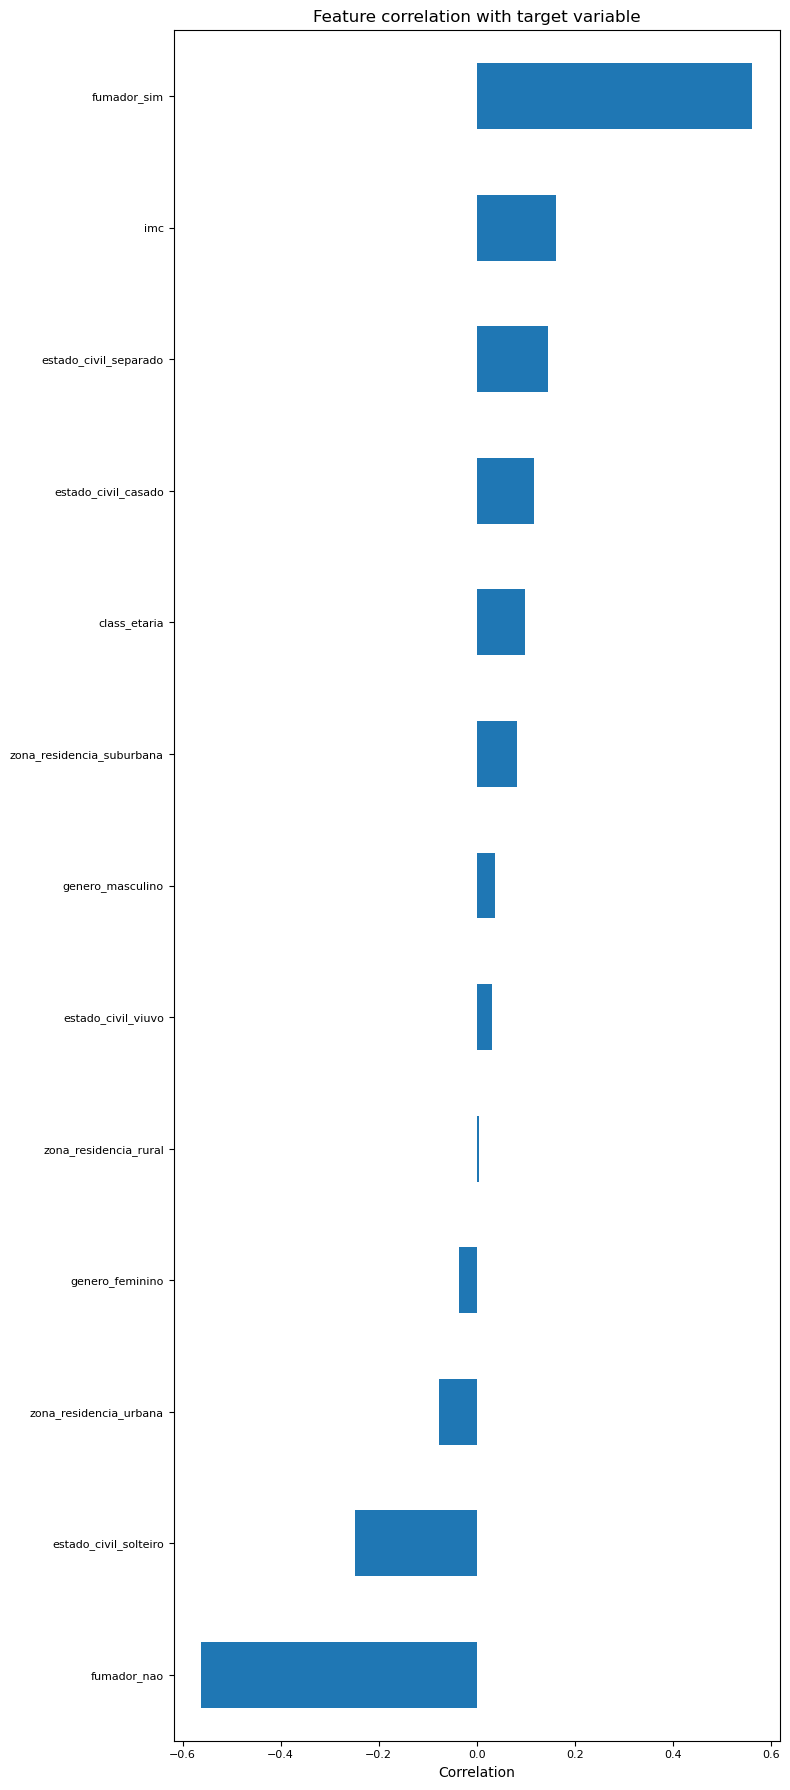

In [194]:
X = data.drop(columns=['Target'])
y = data['Target']

cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]

ord_cols = []
display(cat_cols)

if "class_etaria" in cat_cols:
    ord_cols.append("class_etaria")
    cat_cols.remove("class_etaria")

display(ord_cols)

show_corr_graph(data, cat_cols, ord_cols)

In [195]:
#Stratification for regression
n_bins = 10 
y_binned = pd.qcut(y, q=n_bins, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE, stratify=y_binned
)

# Data Transformation

In [196]:
onehot_trees = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ordinal_trees = OrdinalEncoder().set_output(transform="pandas")
scaler_standard = StandardScaler()

preprocess_for_trees = ColumnTransformer(
   transformers=[("onehot_trees", onehot_trees, cat_cols),
                 ("ordinal_trees", ordinal_trees, ord_cols)],
   remainder="passthrough"
)

onehot_tab = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ordinal_tab = OrdinalEncoder().set_output(transform="pandas")
preprocess_for_tab = ColumnTransformer(
   transformers=[("onehot_encoder", onehot_tab, cat_cols),
                 ("ordinal_trees", ordinal_tab, ord_cols),
                 ("scaler_standard", scaler_standard, num_cols)
                ],
   remainder="passthrough"
)

In [197]:
n_splits = 5
kfold = KFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)

#Stratification for CV
n_bins = 10 
bins = pd.Series(pd.qcut(y_train, q=n_bins, duplicates='drop')).cat.codes
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
folds = list(skf.split(X_train, bins))

In [198]:
#Data transformation for trees
X_train_trees = preprocess_for_trees.fit_transform(X_train)
X_test_trees = preprocess_for_trees.transform(X_test)

In [199]:
#Data transformatiom for tabnet
X_train_tab = preprocess_for_tab.fit_transform(X_train)
X_test_tab = preprocess_for_tab.transform(X_test)

y_train_tab = y_train.values.astype(np.float32).reshape(-1,1)
y_test_tab = y_test.values.astype(np.float32).reshape(-1,1)

# Data Mining with Stacked Models

## Tabnet

In [200]:
model_name = "tabnet"
oof_preds = get_oof_preds(
                            folds,
                            X_train_tab, y_train_tab,
                            model_pred_name = model_name,
                            model_gen_name = model_gen,
                            n_samples_ratio = n_samples_ratio,
                            doAugment=False
)


meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train_tab)

c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 112946567.2|  0:00:00s
epoch 1  | loss: 109018290.93333|  0:00:01s
epoch 2  | loss: 111546563.2|  0:00:01s
epoch 3  | loss: 112719253.33333|  0:00:02s
epoch 4  | loss: 112697241.6|  0:00:03s
epoch 5  | loss: 112360030.13333|  0:00:03s
epoch 6  | loss: 112054354.4|  0:00:04s
epoch 7  | loss: 107609313.33333|  0:00:04s
epoch 8  | loss: 110009893.6|  0:00:05s
epoch 9  | loss: 109592065.06667|  0:00:06s
epoch 10 | loss: 107918747.73333|  0:00:06s
epoch 11 | loss: 107355591.46667|  0:00:07s
epoch 12 | loss: 106310862.93333|  0:00:08s
epoch 13 | loss: 100159182.13333|  0:00:08s
epoch 14 | loss: 103850354.13333|  0:00:09s
epoch 15 | loss: 102774861.06667|  0:00:09s
epoch 16 | loss: 101903124.53333|  0:00:10s
epoch 17 | loss: 94545789.33333|  0:00:11s
epoch 18 | loss: 98799140.93333|  0:00:11s
epoch 19 | loss: 97263028.8|  0:00:12s
epoch 20 | loss: 96017733.86667|  0:00:13s
epoch 21 | loss: 93946798.13333|  0:00:13s
epoch 22 | loss: 92079472.0|  0:00:14s
epoch 23 | loss: 91814

c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 105543314.66667|  0:00:02s
epoch 1  | loss: 99590602.66667|  0:00:04s
epoch 2  | loss: 104966806.93333|  0:00:07s
epoch 3  | loss: 105080469.06667|  0:00:09s
epoch 4  | loss: 104705830.13333|  0:00:11s
epoch 5  | loss: 103616860.8|  0:00:13s
epoch 6  | loss: 97851169.6|  0:00:15s
epoch 7  | loss: 103641178.4|  0:00:18s
epoch 8  | loss: 87676378.4|  0:00:20s
epoch 9  | loss: 101957153.06667|  0:00:23s
epoch 10 | loss: 101614630.66667|  0:00:25s
epoch 11 | loss: 100062618.13333|  0:00:27s
epoch 12 | loss: 98451734.93333|  0:00:29s
epoch 13 | loss: 97200407.2|  0:00:31s
epoch 14 | loss: 97153962.13333|  0:00:33s
epoch 15 | loss: 80591877.33333|  0:00:36s
epoch 16 | loss: 74667262.66667|  0:00:38s
epoch 17 | loss: 89490515.2|  0:00:40s
epoch 18 | loss: 91597688.26667|  0:00:42s
epoch 19 | loss: 90143324.26667|  0:00:45s
epoch 20 | loss: 83182155.86667|  0:00:47s
epoch 21 | loss: 82121357.73333|  0:00:49s
epoch 22 | loss: 85036614.93333|  0:00:51s
epoch 23 | loss: 83655648.

c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 110871797.06667|  0:00:02s
epoch 1  | loss: 109868644.53333|  0:00:04s
epoch 2  | loss: 110870526.66667|  0:00:06s
epoch 3  | loss: 110012056.8|  0:00:09s
epoch 4  | loss: 110210214.4|  0:00:11s
epoch 5  | loss: 109155233.86667|  0:00:13s
epoch 6  | loss: 108541166.4|  0:00:15s
epoch 7  | loss: 109205863.73333|  0:00:17s
epoch 8  | loss: 107476503.73333|  0:00:19s
epoch 9  | loss: 103373693.06667|  0:00:21s
epoch 10 | loss: 106409405.06667|  0:00:24s
epoch 11 | loss: 88472199.73333|  0:00:26s
epoch 12 | loss: 103942743.46667|  0:00:28s
epoch 13 | loss: 103065693.06667|  0:00:30s
epoch 14 | loss: 85434979.2|  0:00:32s
epoch 15 | loss: 99970852.0|  0:00:34s
epoch 16 | loss: 99344482.93333|  0:00:36s
epoch 17 | loss: 97460175.2|  0:00:38s
epoch 18 | loss: 89528071.2|  0:00:40s
epoch 19 | loss: 95166136.53333|  0:00:42s
epoch 20 | loss: 93198420.53333|  0:00:44s
epoch 21 | loss: 91999208.53333|  0:00:47s
epoch 22 | loss: 85012306.66667|  0:00:49s
epoch 23 | loss: 88164778.

c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 96066442.13333|  0:00:01s
epoch 1  | loss: 92360200.8|  0:00:04s
epoch 2  | loss: 95747647.2|  0:00:06s
epoch 3  | loss: 95503059.2|  0:00:08s
epoch 4  | loss: 96280508.8|  0:00:10s
epoch 5  | loss: 90510270.4|  0:00:12s
epoch 6  | loss: 95609839.46667|  0:00:15s
epoch 7  | loss: 94522974.66667|  0:00:17s
epoch 8  | loss: 93659277.6|  0:00:19s
epoch 9  | loss: 93420166.13333|  0:00:21s
epoch 10 | loss: 91446772.8|  0:00:23s
epoch 11 | loss: 90092974.93333|  0:00:25s
epoch 12 | loss: 90005252.26667|  0:00:27s
epoch 13 | loss: 88561548.8|  0:00:29s
epoch 14 | loss: 87567248.8|  0:00:31s
epoch 15 | loss: 86217590.66667|  0:00:33s
epoch 16 | loss: 83990340.0|  0:00:35s
epoch 17 | loss: 83926122.66667|  0:00:37s
epoch 18 | loss: 82690856.26667|  0:00:39s
epoch 19 | loss: 80575625.06667|  0:00:41s
epoch 20 | loss: 79000996.26667|  0:00:43s
epoch 21 | loss: 77712176.53333|  0:00:45s
epoch 22 | loss: 75265855.46667|  0:00:47s
epoch 23 | loss: 59811213.46667|  0:00:49s
epoch 24

c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\Utilizador\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 87251867.2|  0:00:02s
epoch 1  | loss: 87433014.66667|  0:00:04s
epoch 2  | loss: 85727119.73333|  0:00:06s
epoch 3  | loss: 86632893.6|  0:00:08s
epoch 4  | loss: 87297967.73333|  0:00:11s
epoch 5  | loss: 83780300.8|  0:00:13s
epoch 6  | loss: 86552328.0|  0:00:15s
epoch 7  | loss: 85805522.13333|  0:00:17s
epoch 8  | loss: 85279972.8|  0:00:19s
epoch 9  | loss: 84294238.4|  0:00:21s
epoch 10 | loss: 83058626.66667|  0:00:23s
epoch 11 | loss: 82549077.86667|  0:00:25s
epoch 12 | loss: 73955218.66667|  0:00:27s
epoch 13 | loss: 80506332.53333|  0:00:29s
epoch 14 | loss: 79685271.86667|  0:00:32s
epoch 15 | loss: 78288628.0|  0:00:34s
epoch 16 | loss: 76964704.0|  0:00:36s
epoch 17 | loss: 75971034.13333|  0:00:38s
epoch 18 | loss: 71243349.33333|  0:00:40s
epoch 19 | loss: 73189568.0|  0:00:42s
epoch 20 | loss: 70986293.46667|  0:00:44s
epoch 21 | loss: 69949115.33333|  0:00:46s
epoch 22 | loss: 67890375.2|  0:00:48s
epoch 23 | loss: 66029377.2|  0:00:50s
epoch 24 | l

In [201]:
oof_models = save_data.load_oof_models(
    dataset_name=dataset_name,
    model_pred=model_name,
    model_gen=model_gen
)

display(len(oof_models))

mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

for oof_model in oof_models:
    mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_tab)


final_preds = meta_model.predict(mean_prevs)


models_tracker.add_metrics(
                dataset=dataset_name, 
                y_true=y_test_tab.ravel(), 
                y_pred=final_preds, 
                pred_name=model_name,
                gen_name=model_gen, 
                ratio=n_samples_ratio)

5

New model metrics added
File Saved


In [202]:
display(models_tracker.get_summary())

,Dataset,Generative Model,Predicative Model,Synthetic Data Ratio,MAE,MSE,RMSE,R2
2,California Housing,-,xgboost,0.00,0.275269,1.854447e-01,0.430633,0.863098
3,California Housing,-,lightgbm,0.00,0.275137,1.929301e-01,0.439238,0.857572
26,California Housing,ddpm,xgboost,0.25,0.286503,1.981463e-01,0.445136,0.853721
19,California Housing,gan,lightgbm,0.25,0.283502,1.981849e-01,0.445180,0.853692
27,California Housing,ddpm,lightgbm,0.25,0.282377,1.988316e-01,0.445905,0.853215
18,California Housing,gan,xgboost,0.25,0.289142,1.992837e-01,0.446412,0.852881
7,California Housing,copulagan,lightgbm,0.25,0.285197,1.993488e-01,0.446485,0.852833
22,California Housing,vae,xgboost,0.25,0.290652,2.011683e-01,0.448518,0.851490
6,California Housing,copulagan,xgboost,0.25,0.291499,2.013792e-01,0.448753,0.851334
15,California Housing,ctgan,lightgbm,0.25,0.288232,2.034853e-01,0.451093,0.849779


## Catboost

In [203]:
model_name = "catboost"

oof_preds = get_oof_preds(
                            folds,
                            X_train_trees, y_train.to_numpy(),
                            model_pred_name = model_name,
                            model_gen_name = model_gen,
                            n_samples_ratio = n_samples_ratio
)



meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train)

In [204]:
oof_models = save_data.load_oof_models(
    dataset_name=dataset_name,
    model_pred=model_name,
    model_gen=model_gen
)

display(len(oof_models))

mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

for oof_model in oof_models:
    mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_trees)


final_preds = meta_model.predict(mean_prevs)


models_tracker.add_metrics(
                dataset=dataset_name, 
                y_true=y_test.to_numpy().ravel(), 
                y_pred=final_preds, 
                pred_name=model_name,
                gen_name=model_gen, 
                ratio=n_samples_ratio
            )



5

New model metrics added
File Saved


## XGBoost

In [205]:
model_name = "xgboost"

oof_preds = get_oof_preds(
                            folds,
                            X_train_trees, y_train.to_numpy(),
                            model_pred_name = model_name,
                            model_gen_name = model_gen,
                            n_samples_ratio = n_samples_ratio
)



meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train)

Existe o Fold
São iguais
Existe o Fold
São iguais
Existe o Fold
São iguais
Existe o Fold
São iguais
Existe o Fold
São iguais


In [206]:
oof_models = save_data.load_oof_models(
    dataset_name=dataset_name,
    model_pred=model_name,
    model_gen=model_gen
)

display(len(oof_models))

mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

for oof_model in oof_models:
    mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_trees)


final_preds = meta_model.predict(mean_prevs)


models_tracker.add_metrics(
                dataset=dataset_name, 
                y_true=y_test.to_numpy().ravel(), 
                y_pred=final_preds, 
                pred_name=model_name,
                gen_name=model_gen, 
                ratio=n_samples_ratio
            )



5

New model metrics added
File Saved


## LightGBM

In [ ]:
model_name = "lightgbm"

oof_preds = get_oof_preds(
                            folds,
                            X_train_trees, y_train.to_numpy(),
                            model_pred_name = model_name,
                            model_gen_name = model_gen,
                            n_samples_ratio = n_samples_ratio
)


meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train)

Existe o Fold
São iguais


c:\Users\Utilizador\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Existe o Fold
São iguais


In [ ]:
oof_models = save_data.load_oof_models(
    dataset_name=dataset_name,
    model_pred=model_name,
    model_gen=model_gen
)

display(len(oof_models))

mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

for oof_model in oof_models:
    oof_model.feature_name_
    mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_trees)


final_preds = meta_model.predict(mean_prevs)


models_tracker.add_metrics(
                dataset=dataset_name, 
                y_true=y_test.to_numpy().ravel(), 
                y_pred=final_preds, 
                pred_name=model_name,
                gen_name=model_gen, 
                ratio=n_samples_ratio
            )



5

New model metrics added
File Saved


c:\Users\Utilizador\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Utilizador\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Utilizador\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Utilizador\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Utilizador\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
display(models_tracker.metrics_df)

,Dataset,Generative Model,Predicative Model,Synthetic Data Ratio,MAE,MSE,RMSE,R2
0,California Housing,-,tabnet,0.00,0.408754,3.659376e-01,0.604928,0.729851
1,California Housing,-,catboost,0.00,0.301633,2.137656e-01,0.462348,0.842190
2,California Housing,-,xgboost,0.00,0.275269,1.854447e-01,0.430633,0.863098
3,California Housing,-,lightgbm,0.00,0.275137,1.929301e-01,0.439238,0.857572
4,California Housing,copulagan,tabnet,0.25,0.416784,3.775339e-01,0.614438,0.721290
5,California Housing,copulagan,catboost,0.25,0.314072,2.255647e-01,0.474936,0.833480
6,California Housing,copulagan,xgboost,0.25,0.291499,2.013792e-01,0.448753,0.851334
7,California Housing,copulagan,lightgbm,0.25,0.285197,1.993488e-01,0.446485,0.852833
8,California Housing,tvae,tabnet,0.25,0.417490,3.816950e-01,0.617815,0.718218
9,California Housing,tvae,catboost,0.25,0.322342,2.383560e-01,0.488217,0.824037


,RMSE,R2
31,2435.005481,0.777775
35,2444.215113,0.776090


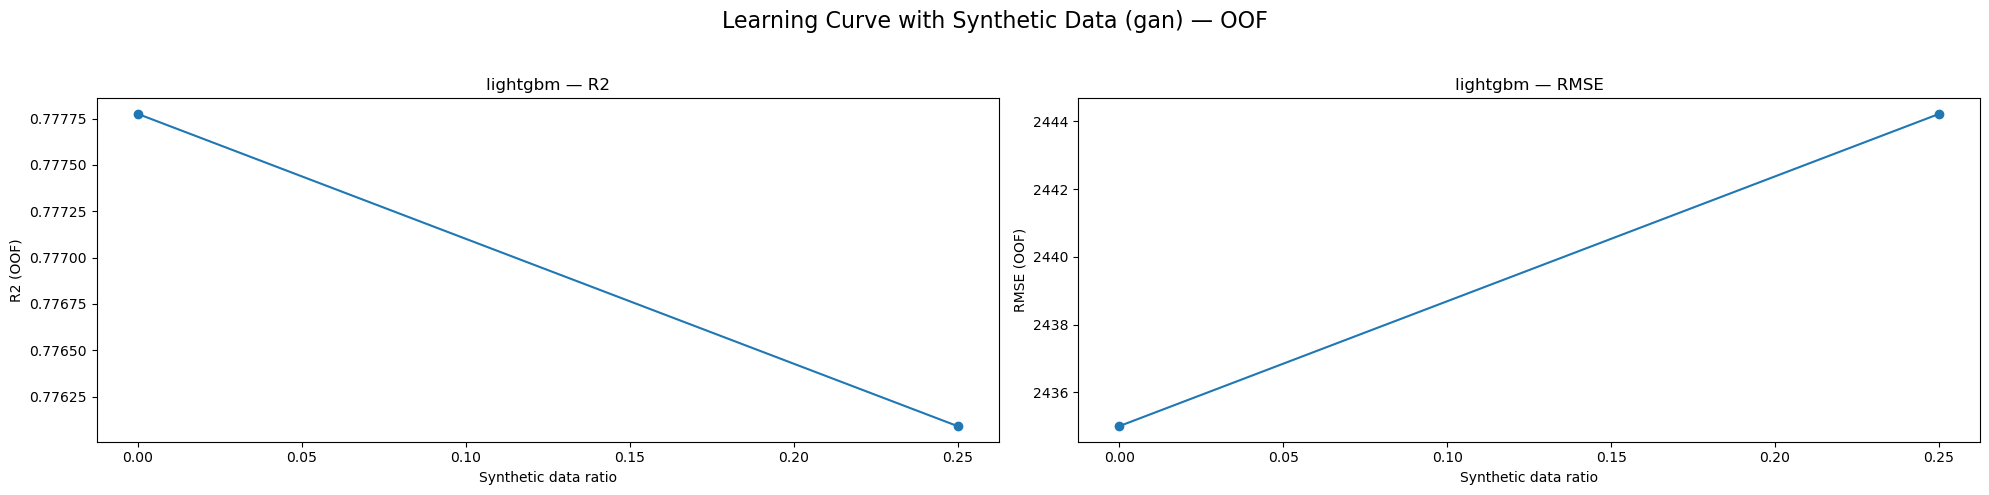

,RMSE,R2
31,2435.005481,0.777775
39,2158.535076,0.825373


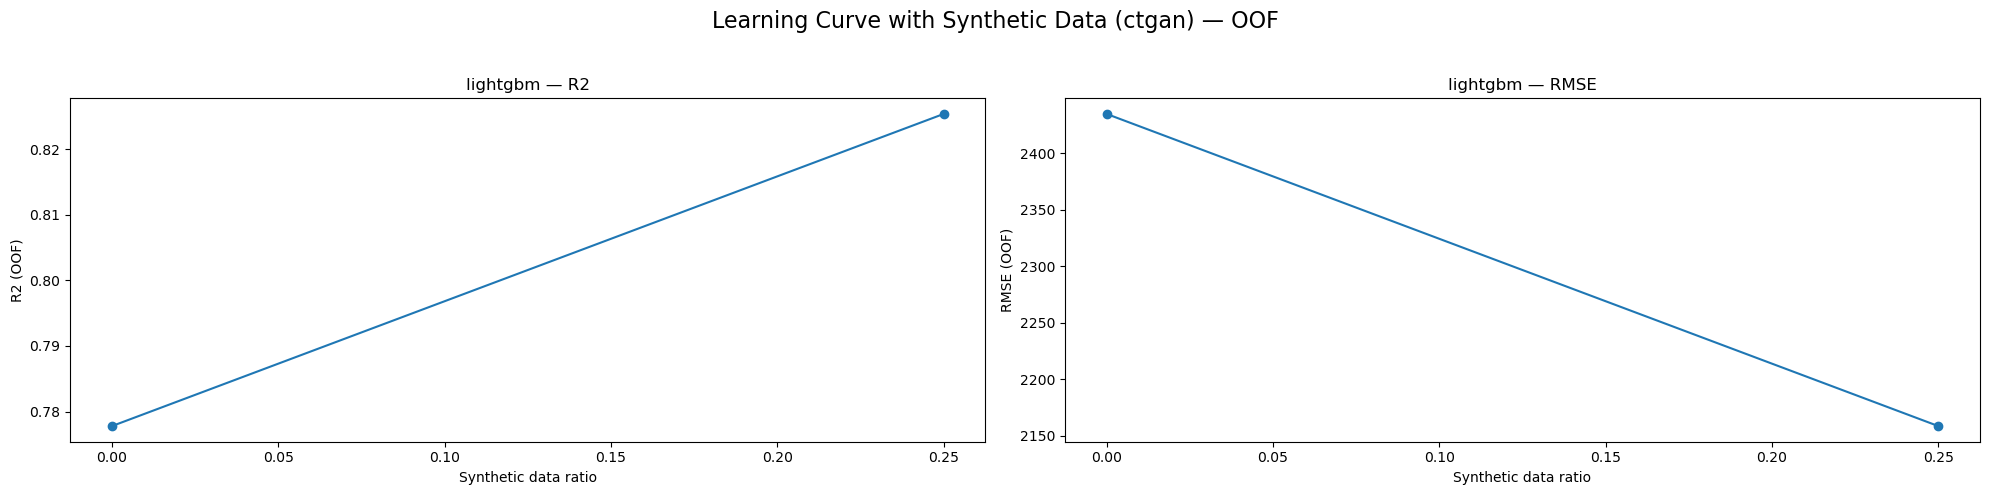

,RMSE,R2
31,2435.005481,0.777775
43,2207.749823,0.817319


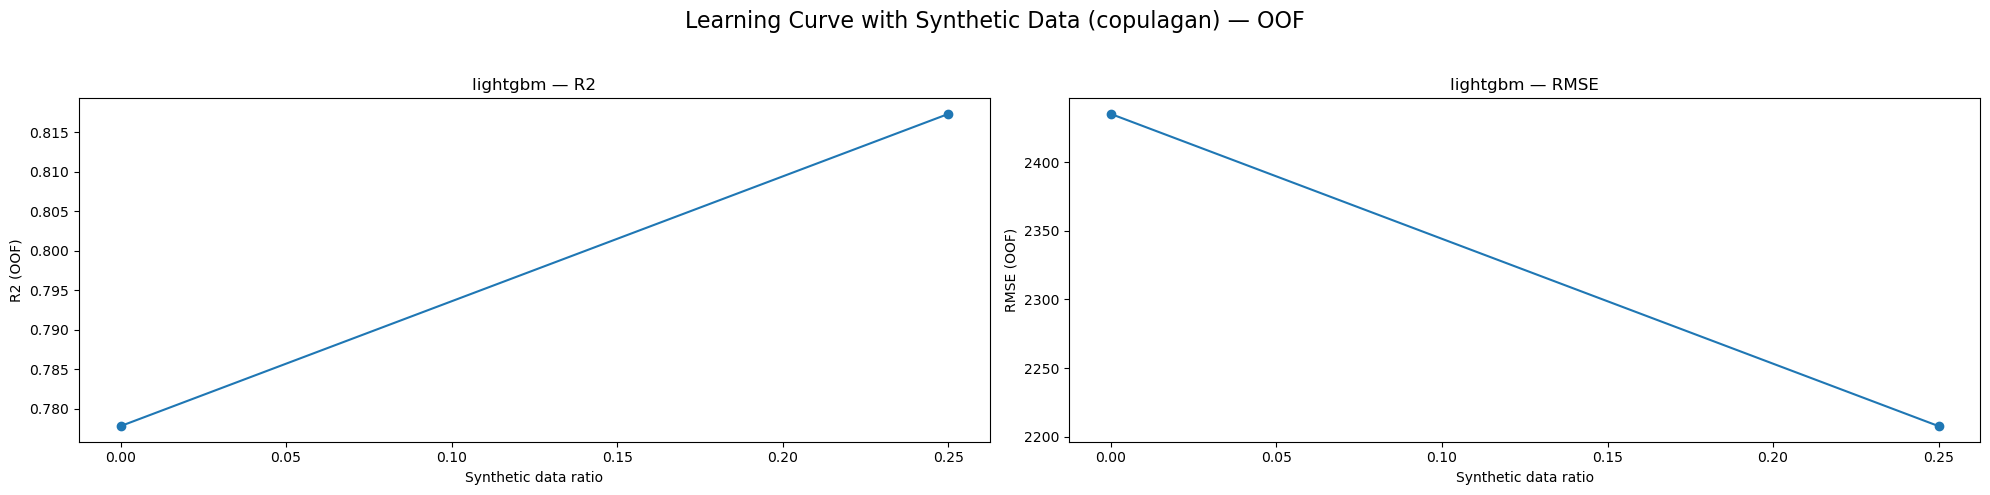

,RMSE,R2
31,2435.005481,0.777775


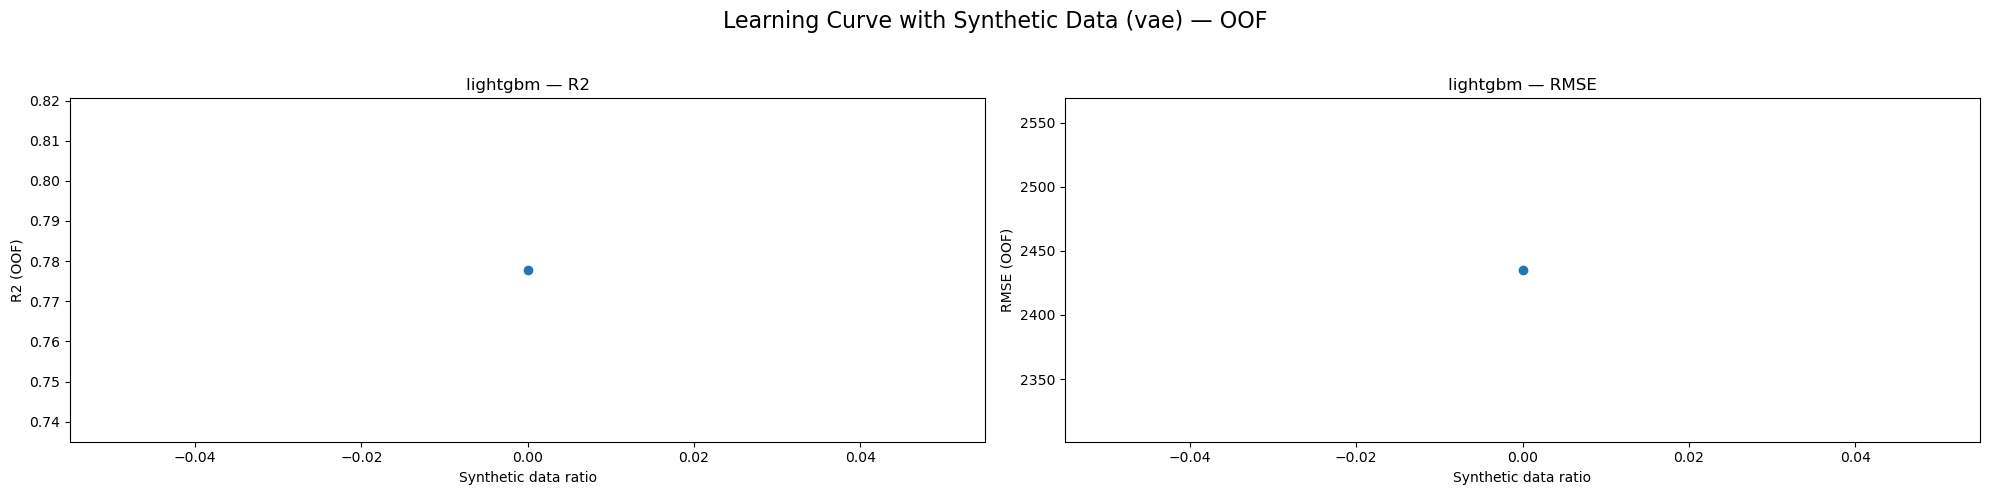

,RMSE,R2
31,2435.005481,0.777775


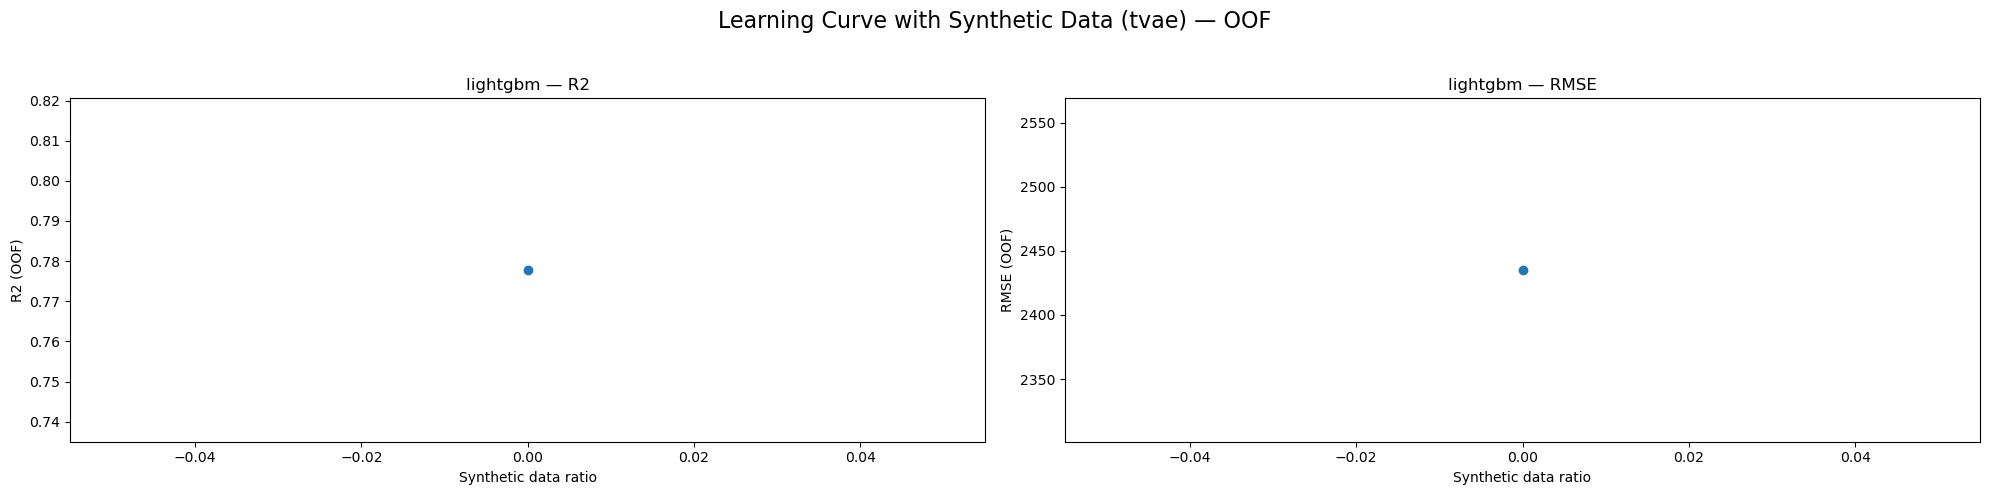

,RMSE,R2
31,2435.005481,0.777775


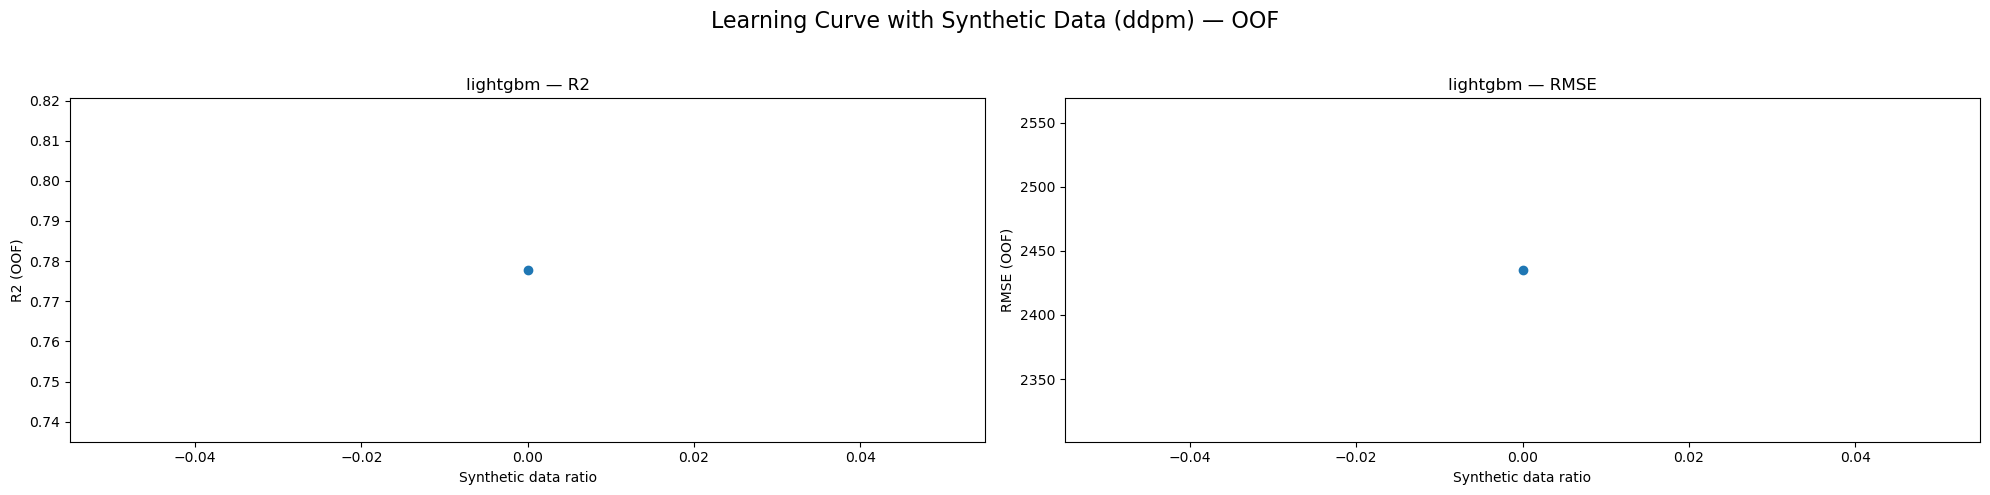

In [ ]:
generative_models_list = ["gan", "ctgan", "copulagan", "vae", "tvae", "ddpm"]
predicative_models_list = ["tabnet", "catboost", "xgboost", "lightgbm"]
datasets_list = ["California Housing", "Custo Seguro"]
metrics_df = models_tracker.metrics_df


for model_gen in generative_models_list:
    df_sel = metrics_df[
    (metrics_df["Dataset"] == "Custo Seguro") &
    (metrics_df["Predicative Model"] == "lightgbm") &
        (
            (metrics_df["Generative Model"] == model_gen) |
            (metrics_df["Generative Model"] == "-")
        )
    ].sort_values("Synthetic Data Ratio")

    ratios = df_sel["Synthetic Data Ratio"].to_list()
    scores = df_sel[["RMSE", "R2"]]

    draw_learning_curve(ratios, scores, model_gen, "lightgbm")


In [ ]:
"""
ratios = [0.5, 0.75, 1.0]
generative_models_list = ["gan", "ctgan", "copulagan", "vae", "tvae", "ddpm"]

for ratio in ratios:
    for model_gen in generative_models_list:

        #-------------------------
        # Tabnet
        #-------------------------
    
        model_name = "tabnet"
        oof_preds = get_oof_preds(
                                    folds,
                                    X_train_tab, y_train_tab,
                                    model_pred_name = model_name,
                                    model_gen_name = model_gen,
                                    n_samples_ratio = n_samples_ratio,
                                    doAugment=False
        )


        meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train_tab)

        oof_models = save_data.load_oof_models(
            dataset_name=dataset_name,
            model_pred=model_name,
            model_gen=model_gen
        )

        display(len(oof_models))

        mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

        for oof_model in oof_models:
            mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_tab)


        final_preds = meta_model.predict(mean_prevs)


        models_tracker.add_metrics(
                        dataset=dataset_name, 
                        y_true=y_test_tab.ravel(), 
                        y_pred=final_preds, 
                        pred_name=model_name,
                        gen_name=model_gen, 
                        ratio=n_samples_ratio)


        #-------------------------
        #Catboost
        #-------------------------

        model_name = "catboost"

        oof_preds = get_oof_preds(
                                    folds,
                                    X_train_trees, y_train.to_numpy(),
                                    model_pred_name = model_name,
                                    model_gen_name = model_gen,
                                    n_samples_ratio = n_samples_ratio
        )



        meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train)


        oof_models = save_data.load_oof_models(
            dataset_name=dataset_name,
            model_pred=model_name,
            model_gen=model_gen
        )

        display(len(oof_models))

        mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

        for oof_model in oof_models:
            mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_trees)


        final_preds = meta_model.predict(mean_prevs)


        models_tracker.add_metrics(
                        dataset=dataset_name, 
                        y_true=y_test.to_numpy().ravel(), 
                        y_pred=final_preds, 
                        pred_name=model_name,
                        gen_name=model_gen, 
                        ratio=n_samples_ratio
                    )

        #-------------------------
        #xgboost
        #-------------------------

        model_name = "xgboost"

        oof_preds = get_oof_preds(
                                    folds,
                                    X_train_trees, y_train.to_numpy(),
                                    model_pred_name = model_name,
                                    model_gen_name = model_gen,
                                    n_samples_ratio = n_samples_ratio
        )



        meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train)

        oof_models = save_data.load_oof_models(
            dataset_name=dataset_name,
            model_pred=model_name,
            model_gen=model_gen
        )

        display(len(oof_models))

        mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

        for oof_model in oof_models:
            oof_model.feature_name_
            mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_trees)


        final_preds = meta_model.predict(mean_prevs)


        models_tracker.add_metrics(
                        dataset=dataset_name, 
                        y_true=y_test.to_numpy().ravel(), 
                        y_pred=final_preds, 
                        pred_name=model_name,
                        gen_name=model_gen, 
                        ratio=n_samples_ratio
                    )
    
        #-------------------------
        #lightgbm
        #-------------------------

        model_name = "lightgbm"

        oof_preds = get_oof_preds(
                                    folds,
                                    X_train_trees, y_train.to_numpy(),
                                    model_pred_name = model_name,
                                    model_gen_name = model_gen,
                                    n_samples_ratio = n_samples_ratio
        )


        meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train)
        
        oof_models = save_data.load_oof_models(
            dataset_name=dataset_name,
            model_pred=model_name,
            model_gen=model_gen
        )

        display(len(oof_models))

        mean_prevs = np.zeros(len(y_test)).reshape(-1,1)

        for oof_model in oof_models:
            oof_model.feature_name_
            mean_prevs += (1/n_splits)*test_pred_model(oof_model, X_test_trees)


        final_preds = meta_model.predict(mean_prevs)


        models_tracker.add_metrics(
                        dataset=dataset_name, 
                        y_true=y_test.to_numpy().ravel(), 
                        y_pred=final_preds, 
                        pred_name=model_name,
                        gen_name=model_gen, 
                        ratio=n_samples_ratio
                    )

    display(models_tracker.metrics_df)
"""

'\nratios = [0.5, 0.75, 1.0]\ngenerative_models_list = ["gan", "ctgan", "copulagan", "vae", "tvae", "ddpm"]\n\nfor ratio in ratios:\n    for model_gen in generative_models_list:\n    \n        model_name = "tabnet"\n        oof_preds = get_oof_preds(\n                                    folds,\n                                    X_train_tab, y_train_tab,\n                                    model_pred_name = model_name,\n                                    model_gen_name = model_gen,\n                                    n_samples_ratio = n_samples_ratio,\n                                    doAugment=False\n        )\n\n\n        meta_model = train_meta_model(X_tr = oof_preds, y_tr = y_train_tab)\n\n        oof_models = save_data.load_oof_models(\n            dataset_name=dataset_name,\n            model_pred=model_name,\n            model_gen=model_gen\n        )\n\n        display(len(oof_models))\n\n        mean_prevs = np.zeros(len(y_test)).reshape(-1,1)\n\n        for oof_model i